In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [17]:
test_models_dir="models"
test_scenes_dir="scenes"
test_A={
    "scenes": {"e1.png", "e2.png", "e3.png", "e4.png", "e5.png"},
    "products":{"0.jpg", "1.jpg", "11.jpg", "19.jpg", "24.jpg", "26.jpg", "25.jpg"}
}
debug=False



In [29]:
def detect(product, scene):
    # Load the query and the train images
    img_train = cv2.imread(test_scenes_dir+'/'+scene,0) # trainImage
    img_query = cv2.imread(test_models_dir+'/'+product,0) # queryImage

    # Creating SIFT object
    sift = cv2.SIFT_create()

    # Detecting Keypoints in the two images
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    if debug:
        # Visualizing the found Keypoints
        img_visualization = cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_visualization)
        plt.show()
        img_visualization = cv2.drawKeypoints(img_query,kp_query,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_visualization)
        plt.show()

    # Computing the descriptors for each keypoint
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train, kp_train)

    # Initializing the matching algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # Matching the descriptors
    matches = flann.knnMatch(des_query,des_train,k=2)
    # Keeping only good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            good.append(m)
            
    # If we have at least 10 matches we find the box of the object
    MIN_MATCH_COUNT = 20
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)        
        # Calculating homography based on correspondences
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # Matches mask for visualization of only matches used by RANSAC
        matchesMask = mask.ravel().tolist()
        # Apply homography to project corners of the query image into the image
        h,w = img_query.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)      
        # Drawing bounding box
        img_train = cv2.polylines(img_train,[np.int32(dst)],True,(255,0,0),3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    # Drawing matches
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
    plt.imshow(img3, 'gray')
    plt.show()
    
    print(len(good))

Not enough matches are found - 9/20


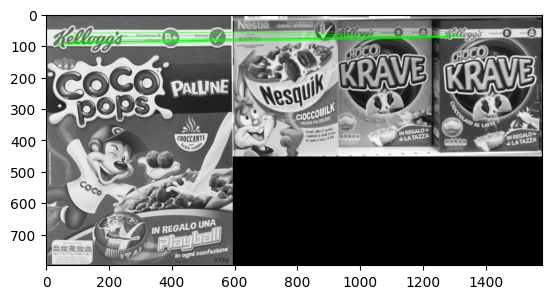

9
Not enough matches are found - 0/20


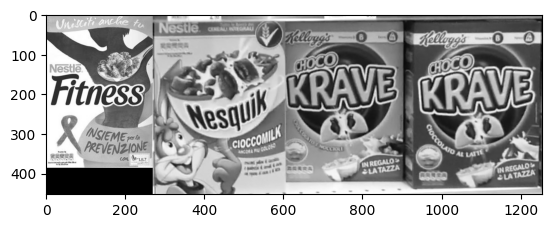

0


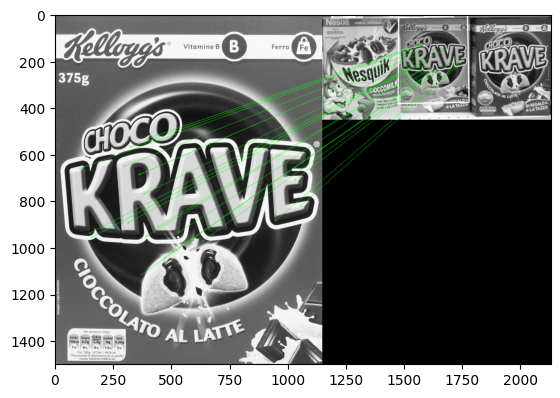

37


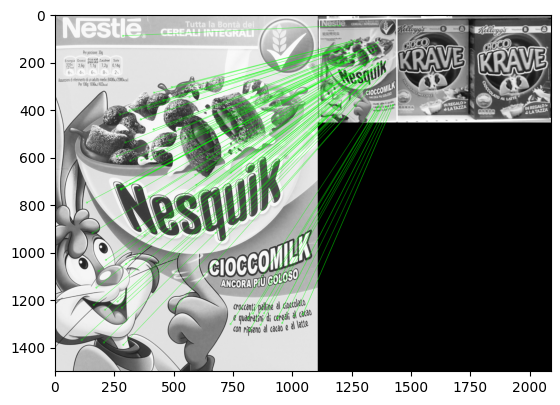

102
Not enough matches are found - 0/20


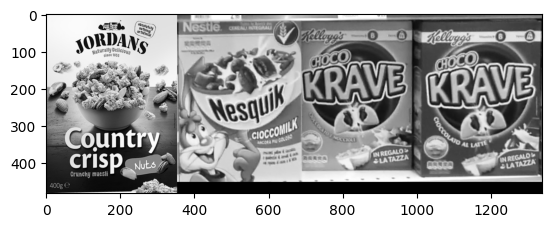

0
Not enough matches are found - 16/20


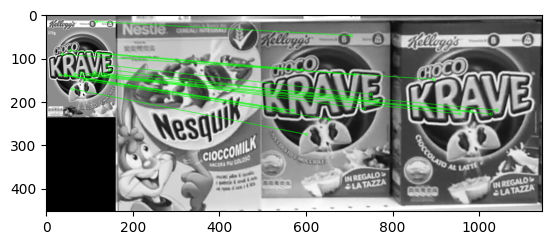

16
Not enough matches are found - 11/20


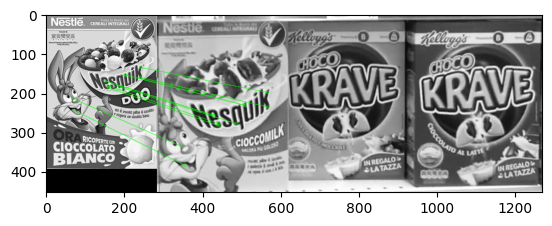

11


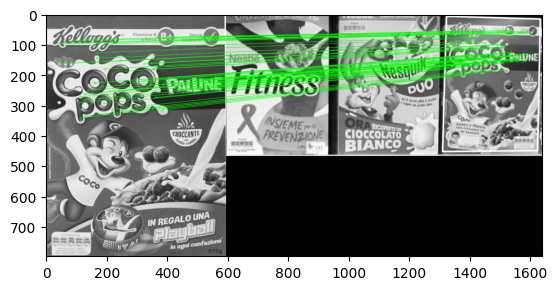

91


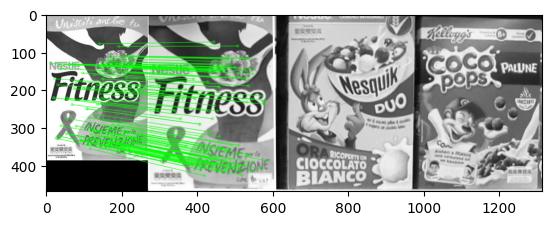

115
Not enough matches are found - 6/20


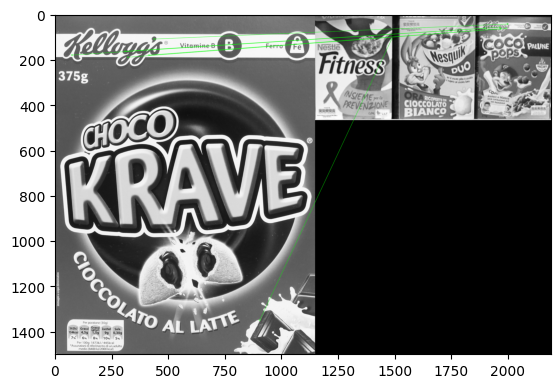

6


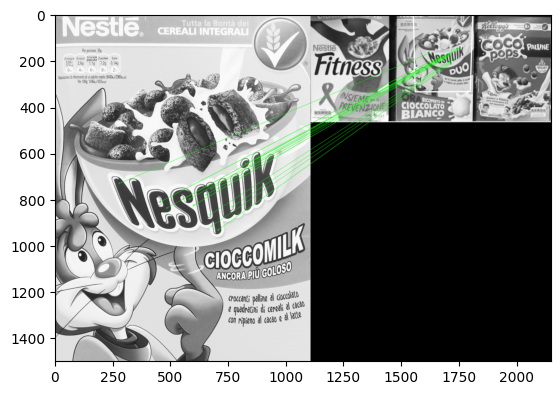

28
Not enough matches are found - 0/20


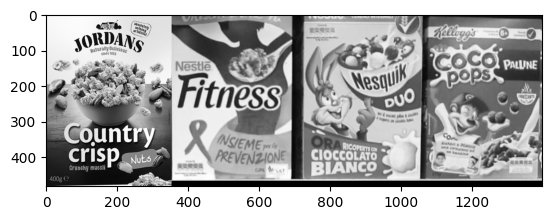

0
Not enough matches are found - 0/20


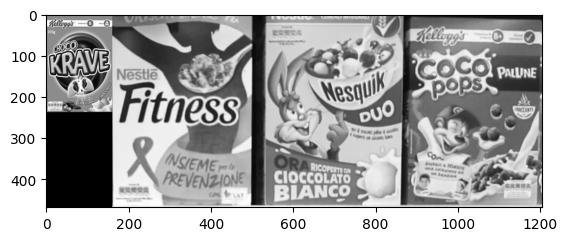

0


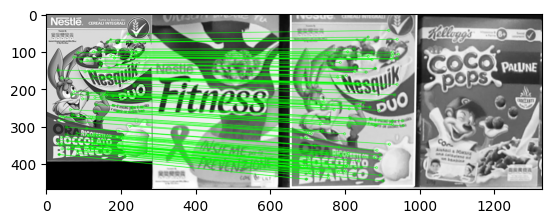

117
Not enough matches are found - 0/20


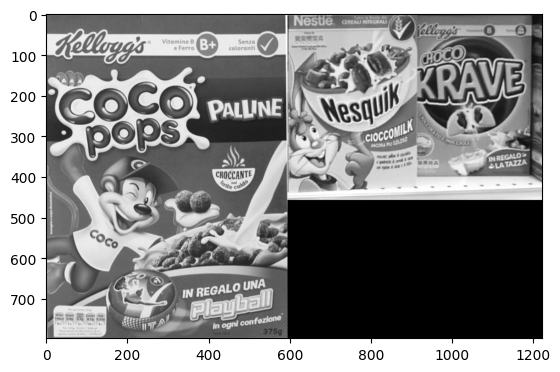

0
Not enough matches are found - 1/20


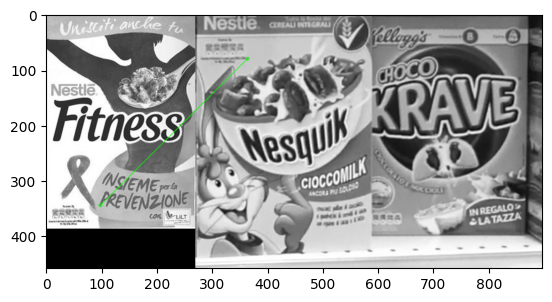

1


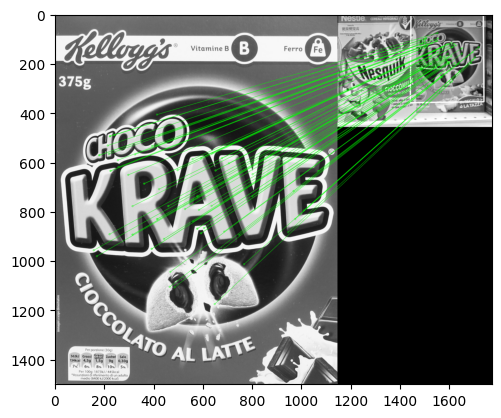

68


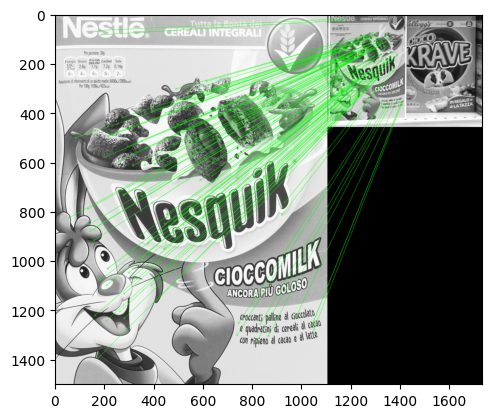

118
Not enough matches are found - 0/20


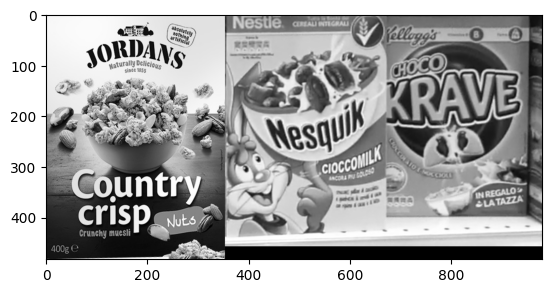

0


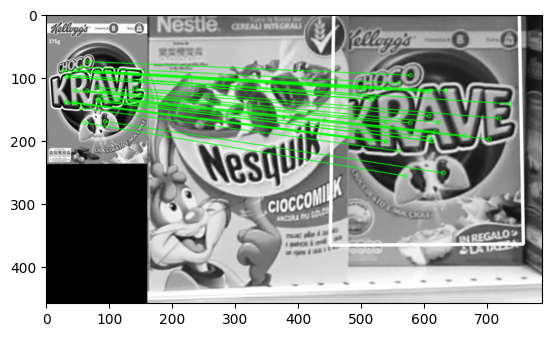

33
Not enough matches are found - 15/20


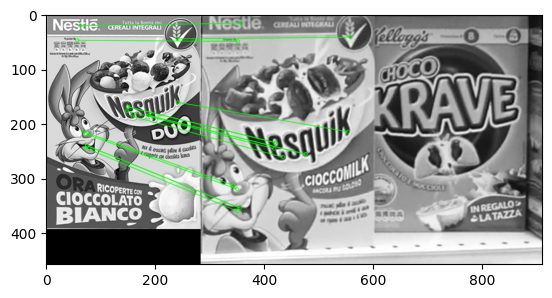

15


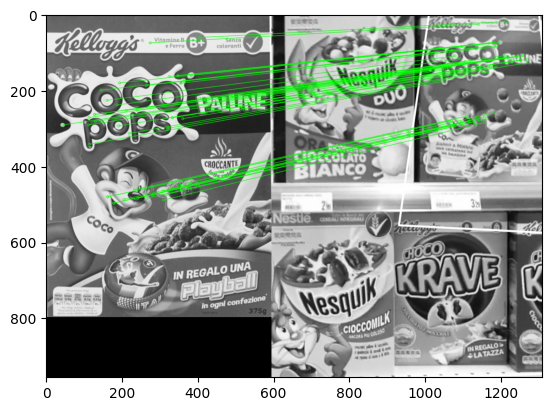

83
Not enough matches are found - 0/20


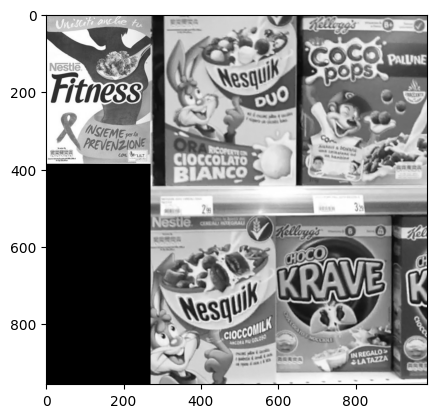

0


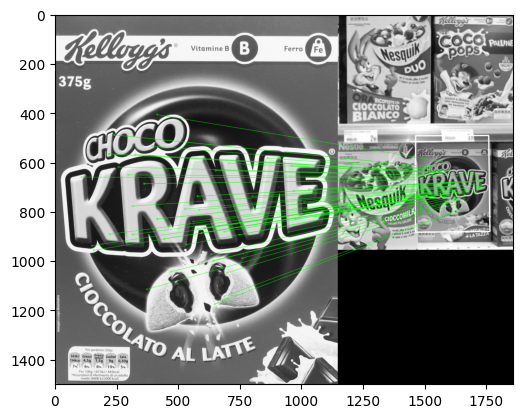

59


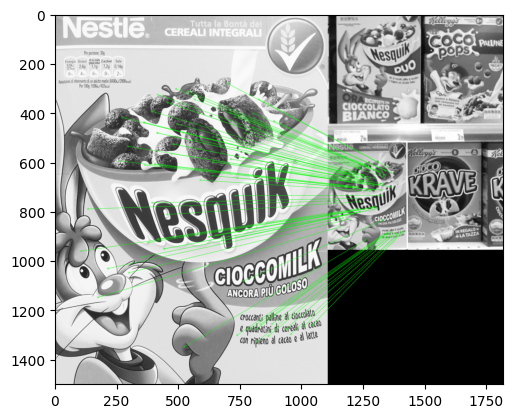

75
Not enough matches are found - 0/20


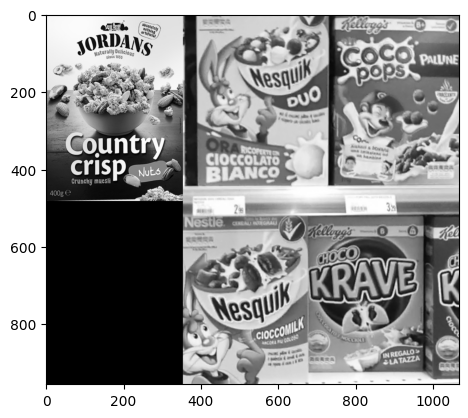

0


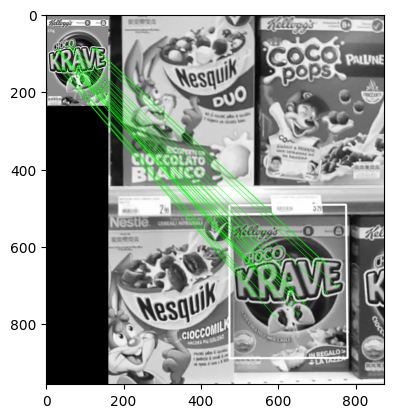

31


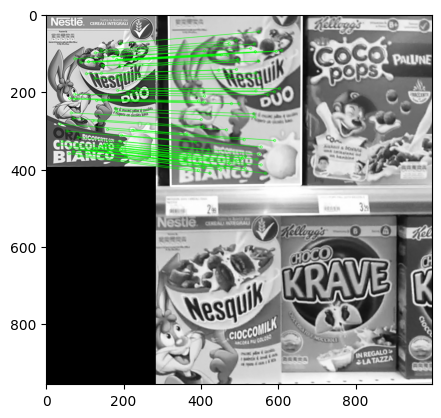

78


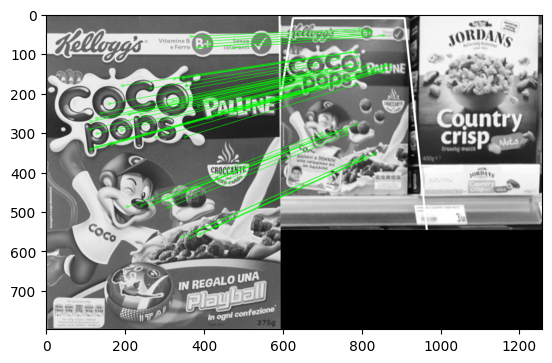

89
Not enough matches are found - 0/20


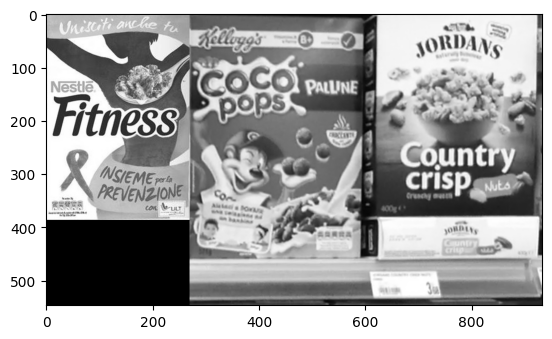

0
Not enough matches are found - 3/20


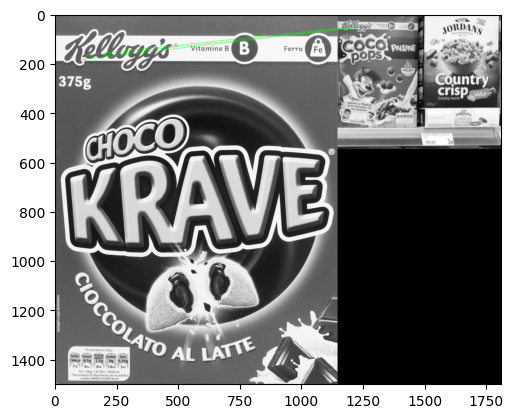

3
Not enough matches are found - 0/20


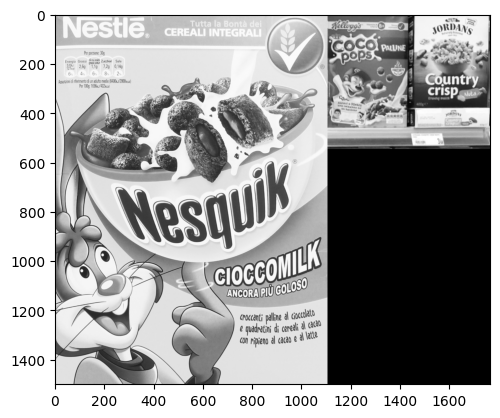

0


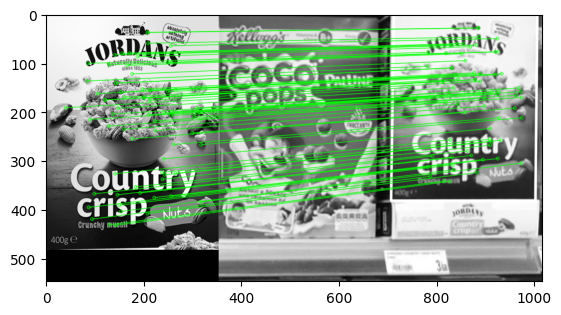

70
Not enough matches are found - 0/20


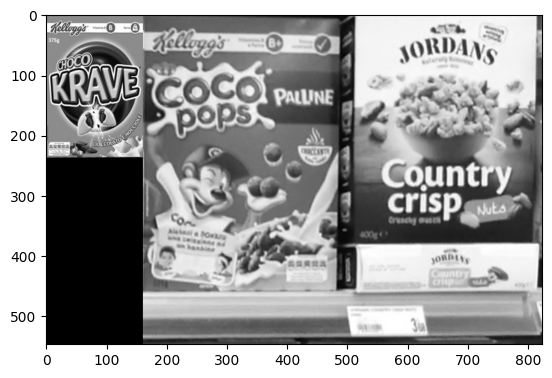

0
Not enough matches are found - 0/20


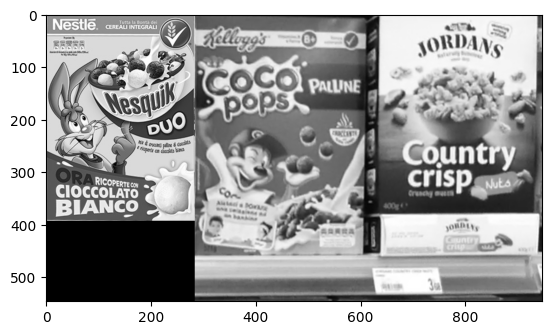

0


In [30]:
for s in test_A["scenes"]:
    for p in test_A["products"]:
        detect(p,s)
    